In [252]:
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torchvision import transforms
from transformers import OFATokenizer, OFAModel
from transformers.models.ofa.generate import sequence_generator

In [253]:
import pandas as pd
from PIL import Image
import io
import base64

# Load the data
data = pd.read_csv('dataset/vision_language_examples.tsv', delimiter='\t', header=None)

# Select the first row's image data (assuming it's in the second column)
image_data = data.iloc[7, 1]

# Decode the base64 string
image_bytes = base64.b64decode(image_data)

# Convert to a bytes buffer
image_buffer = io.BytesIO(image_bytes)

# Open the image
image = Image.open(image_buffer)

# Display the image if you are in a Jupyter notebook environment
# image.show()

In [254]:
# also take the caption
caption = data.iloc[7, 2]
caption

'ewa makai teacher walking around classroom while giving a lecture to her students.'

In [255]:
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
resolution = 480
patch_resize_transform = transforms.Compose([
        lambda image: image.convert("RGB"),
        transforms.Resize((resolution, resolution), interpolation=Image.BICUBIC),
        transforms.ToTensor(), 
        transforms.Normalize(mean=mean, std=std)
    ])

In [256]:
ckpt_dir = "/Users/iustingrigoras/Desktop/OFA/OFA-base"
tokenizer = OFATokenizer.from_pretrained(ckpt_dir)

/Users/iustingrigoras/Desktop/OFA/OFA-base
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


In [257]:
# txt = " what city are the yankees from?"
# txt = " what do you think the girls did to the man?"
# txt = "How did [person2 ] get the money that’s in front of her?"
# txt = "Why is [person4] pointing at [person1]?"
# txt = "Why is [person1] pointing a gun at [person2]?"
# txt = "What would [person1] do if she caught [person2] and [person3] whispering?"
txt = "What class does [person1] teach?"
# txt = "How did the girl get the money that’s in front of her?"
# txt = "Is that a giraffe or an elephant?"
# txt = "Who is feeding the giraffe behind the man?"
# txt = "Is there any fence near the animal behind the man?"
# txt = "On which side of the image is the man?"
# txt = "Is the person's hair brown and long?"
# txt = "What is the person in front of the refrigerator wearing?"
# txt = "What is the color of the shirt?"
# txt = "What is hanging on the wall?"
# txt = "Does he look like he has children?"
# txt = 'What can you see in the image?'
# txt = 'Is the woman on the left pouring wine?'
# txt = 'What does the image describe?'
# txt = 'Where is the image on the left taken?'
# txt = "Why do you think he is wearing a suit?"
# txt = " what currency is this?"
# txt = "what number is the small hand on?"
# txt = "what sort of vehicle uses this item?"
# txt = "why is the woman pointing a gun at the man?"
# txt = "What movie is this character from?"
# txt = "What is the name of the man who built the arc in the bible due to this natural catastrophe?"
# txt = "What natural catastrophe is this?"
inputs = tokenizer([txt], return_tensors="pt").input_ids
image = Image.open('examples/vcr/vcr_6310.png')    
patch_img = patch_resize_transform(image).unsqueeze(0)

In [258]:
model = OFAModel.from_pretrained(ckpt_dir, use_cache=True, output_atentions=True, output_hidden_states=True)
generator = sequence_generator.SequenceGenerator(
                    tokenizer=tokenizer,
                    beam_size=3,
                    max_len_b=20, 
                    min_len=0,
                    no_repeat_ngram_size=3,
                    temperature=0.5,
                )

In [259]:
data = {}
data["net_input"] = {"input_ids": inputs, 'patch_images': patch_img, 'patch_masks':torch.tensor([True])}
gen_output = generator.generate([model], data)
gen = [gen_output[i][0]["tokens"] for i in range(len(gen_output))]

Type of input_ids: <class 'torch.Tensor'>
Shape of input_ids: torch.Size([1, 11])


In [260]:
decoded_output = tokenizer.batch_decode(gen, skip_special_tokens=True)
print(decoded_output)

[' yes']


In [261]:
model = OFAModel.from_pretrained(ckpt_dir, use_cache=False)
gen = model.generate(inputs, patch_images=patch_img, num_beams=4, no_repeat_ngram_size=3,
                     temperature=2.0, max_length=20, min_length=10, num_return_sequences=1,
                     output_scores=True, output_attentions=True, output_hidden_states=True,
                     return_dict_in_generate=True, use_cache=False)
# gen = model.generate(inputs, patch_images=patch_img, num_beams=3, temperature=0.3, num_return_sequences=2)

# Check what gen actually contains
if isinstance(gen, torch.Tensor):
    # If gen is directly a tensor, decode it
    decoded_output = tokenizer.batch_decode(gen, skip_special_tokens=True)
elif "sequences" in dir(gen): 
    # If gen is a dictionary-like object with sequences
    decoded_output = tokenizer.batch_decode(gen.sequences, skip_special_tokens=True)
else:
    # If gen contains something else or you are unsure
    print("The structure of the generation output is not recognized. Check the output structure.")
    decoded_output = None

if decoded_output:                                          
    print(decoded_output)
else:
    print("No valid token sequences were found to decode.")

Type of input_ids: <class 'torch.Tensor'>
Shape of input_ids: torch.Size([1, 11])
[" i don't know what i am talking about"]


In order to generate tuples for scores, attentions and hidden states for the encoder and decoder, respectively, refer to `generation_utils` by cmd+click to `model.generate`. In order to output them, specify as args:

> `output_scores=True, output_attentions=True, output_hidden_states=True, >  return_dict_in_generate=True`

Then take the `gen` object and output them as below, args taken from class `BeamSearchEncoderDecoderOutput` from `generation_utils.py`:

`get_normalized_probs()` returns the log probabilities of the output, the same as gen.scores

In [262]:
model.get_normalized_probs(gen.scores, log_probs=True, sample=True)

tensor([[-16.4953, -26.0800,     -inf,  ..., -26.9596, -26.3855, -26.7262],
        [-16.4953, -26.0800,     -inf,  ..., -26.9596, -26.3855, -26.7262],
        [-16.4953, -26.0800,     -inf,  ..., -26.9596, -26.3855, -26.7262],
        [-16.4953, -26.0800,     -inf,  ..., -26.9596, -26.3855, -26.7262]])

In [264]:
scores = gen.scores
scores[0]

tensor([[-16.4956, -26.0803,     -inf,  ..., -26.9598, -26.3857, -26.7264],
        [-16.4956, -26.0803,     -inf,  ..., -26.9598, -26.3857, -26.7264],
        [-16.4956, -26.0803,     -inf,  ..., -26.9598, -26.3857, -26.7264],
        [-16.4956, -26.0803,     -inf,  ..., -26.9598, -26.3857, -26.7264]])

In [265]:
# Process scores
if 'scores' in gen:
    scores = gen.scores  # List of tensors, each tensor corresponds to scores of a token
    scores = torch.stack(scores)  # Shape: (seq_length, batch_size, vocab_size)
    scores = torch.nn.functional.softmax(scores, dim=-1)  # Convert logits to probabilities

    # Select the top tokens for each position
    topk_values, topk_indices = torch.topk(scores, 10, dim=-1)  # Get top 5 tokens for each position

In [266]:
sequence_scores = topk_values[0, 0].tolist()
sequence_scores

[0.8795931935310364,
 0.11670047789812088,
 8.530895865987986e-05,
 8.039633394218981e-05,
 5.402575698099099e-05,
 4.703455124399625e-05,
 4.5110944483894855e-05,
 4.2291976569686085e-05,
 4.1773117118282244e-05,
 3.8904236134840176e-05]

In [267]:
sequence_tokens = topk_indices[0, 0].tolist()
sequence_tokens

[4420, 117, 45, 939, 11380, 112, 47, 132, 5, 70]

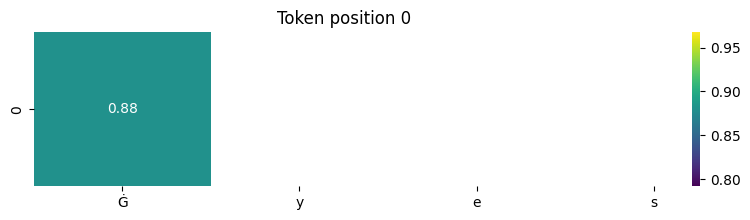

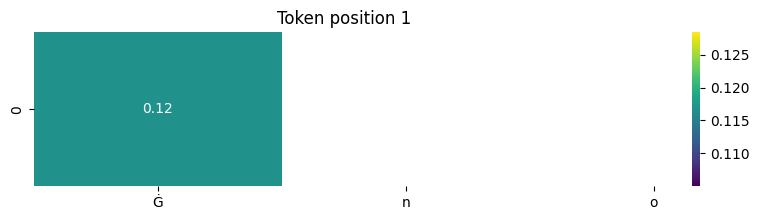

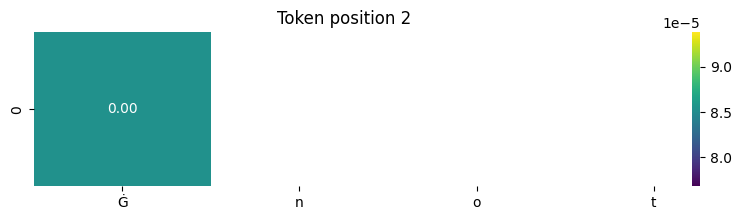

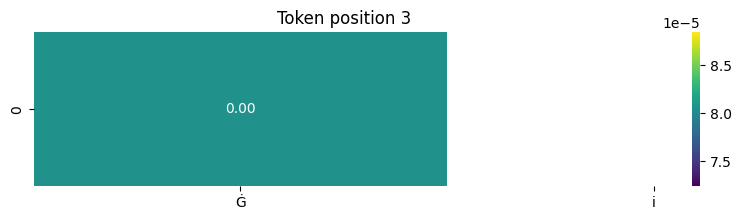

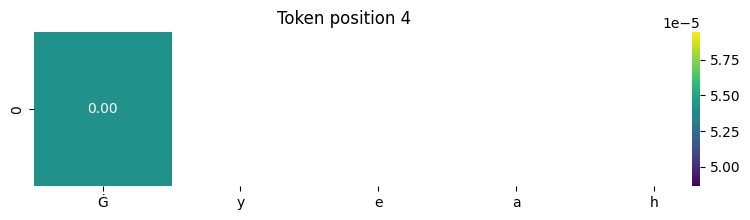

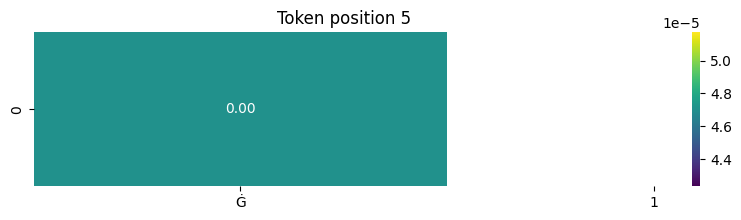

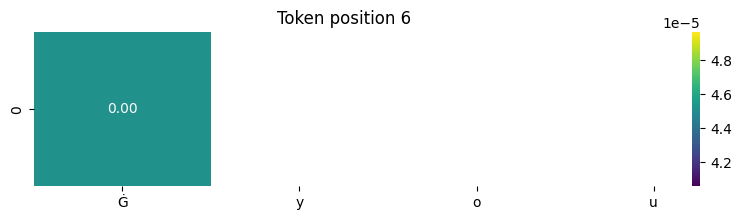

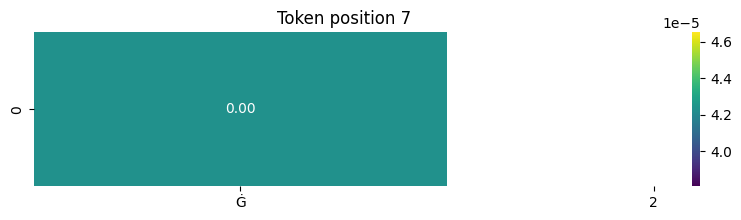

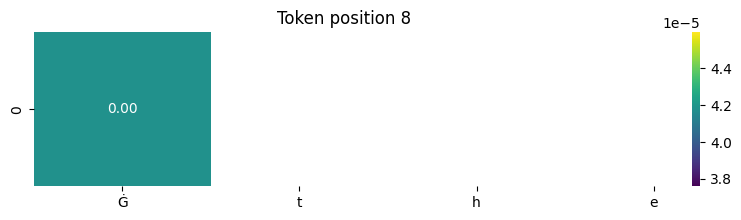

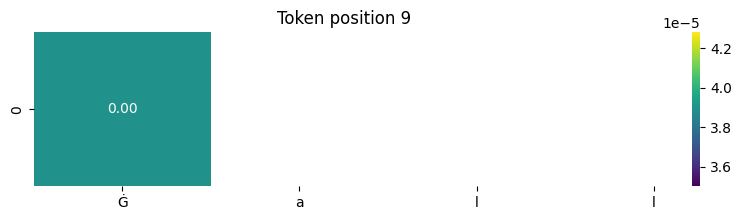

In [268]:
import numpy as np
for position in range(len(sequence_scores)):
    scores = np.array(sequence_scores[position]).reshape(1, -1)
    tokens = sequence_tokens[position]
    token_labels = tokenizer.convert_ids_to_tokens(tokens)  # Convert indices to token strings
    plt.figure(figsize=(10, 2))
    sns.heatmap(scores, annot=True, fmt=".2f", xticklabels=token_labels, cmap='viridis')
    plt.title(f"Token position {position}")
    plt.show()

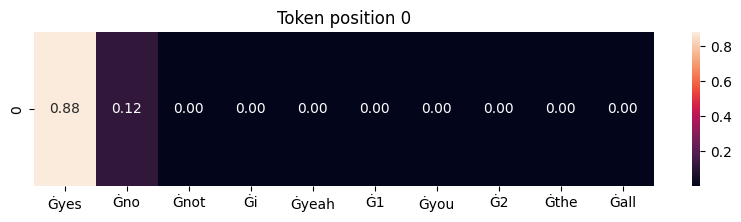

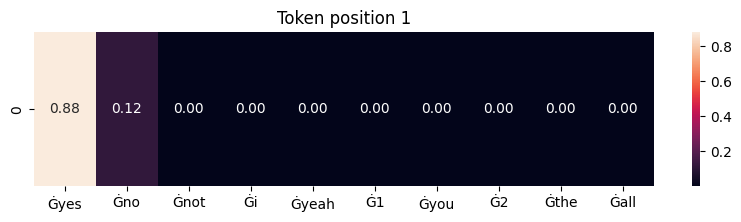

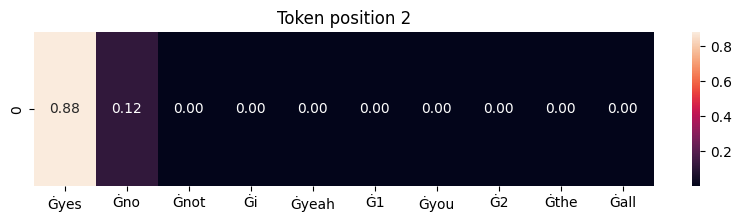

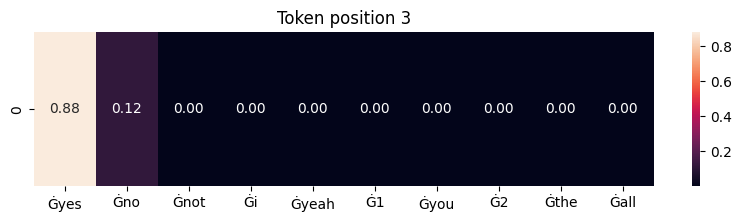

In [269]:
# Assuming you're dealing with the first sequence in the batch
sequence_scores = topk_values[0]
sequence_tokens = topk_indices[0]

# For each position, get the probability of the top 5 tokens
for position in range(sequence_scores.size(0)):
    plt.figure(figsize=(10, 2))
    sns.heatmap(sequence_scores[position].unsqueeze(0).numpy(), annot=True, fmt=".2f",
                xticklabels=tokenizer.convert_ids_to_tokens(sequence_tokens[position].tolist()))
    plt.title(f"Token position {position}")
    plt.show()

Token position 0 probabilities: [8.7959319e-01 1.1670048e-01 8.5308959e-05 8.0396334e-05 5.4025757e-05
 4.7034551e-05 4.5110944e-05 4.2291977e-05 4.1773117e-05 3.8904236e-05]
Tokens: ['Ġyes', 'Ġno', 'Ġnot', 'Ġi', 'Ġyeah', 'Ġ1', 'Ġyou', 'Ġ2', 'Ġthe', 'Ġall']


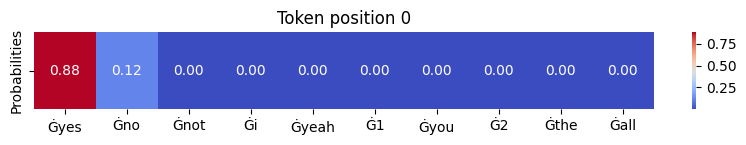

Token position 1 probabilities: [8.7959319e-01 1.1670048e-01 8.5308959e-05 8.0396334e-05 5.4025757e-05
 4.7034551e-05 4.5110944e-05 4.2291977e-05 4.1773117e-05 3.8904236e-05]
Tokens: ['Ġyes', 'Ġno', 'Ġnot', 'Ġi', 'Ġyeah', 'Ġ1', 'Ġyou', 'Ġ2', 'Ġthe', 'Ġall']


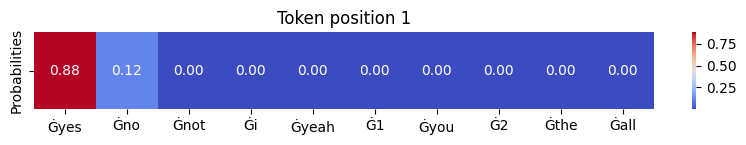

Token position 2 probabilities: [8.7959319e-01 1.1670048e-01 8.5308959e-05 8.0396334e-05 5.4025757e-05
 4.7034551e-05 4.5110944e-05 4.2291977e-05 4.1773117e-05 3.8904236e-05]
Tokens: ['Ġyes', 'Ġno', 'Ġnot', 'Ġi', 'Ġyeah', 'Ġ1', 'Ġyou', 'Ġ2', 'Ġthe', 'Ġall']


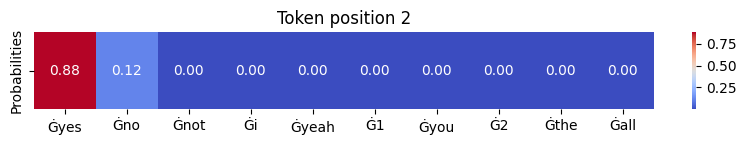

Token position 3 probabilities: [8.7959319e-01 1.1670048e-01 8.5308959e-05 8.0396334e-05 5.4025757e-05
 4.7034551e-05 4.5110944e-05 4.2291977e-05 4.1773117e-05 3.8904236e-05]
Tokens: ['Ġyes', 'Ġno', 'Ġnot', 'Ġi', 'Ġyeah', 'Ġ1', 'Ġyou', 'Ġ2', 'Ġthe', 'Ġall']


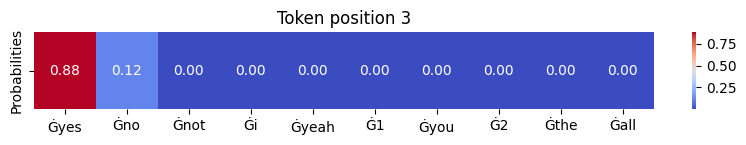

In [270]:
for i in range(sequence_scores.size(0)):  # Iterate over each token position
    plt.figure(figsize=(10, 1))
    token_probs = sequence_scores[i].detach().numpy()  # Detach and convert to numpy if using PyTorch
    token_labels = tokenizer.convert_ids_to_tokens(sequence_tokens[i].tolist())
    
    # Print actual probabilities for debugging
    print(f"Token position {i} probabilities:", token_probs)
    print("Tokens:", token_labels)
    
    sns.heatmap(token_probs.reshape(1, -1), annot=True, cmap='coolwarm', fmt=".2f",
                xticklabels=token_labels, yticklabels=['Probabilities'])
    plt.title(f"Token position {i}")
    plt.show()

In [271]:
encoder_attentions = gen.encoder_attentions
encoder_hidden_states = gen.encoder_hidden_states

In [272]:
decoder_attentions = gen.decoder_attentions
cross_attentions = gen.cross_attentions
decoder_hidden_states = gen.decoder_hidden_states

In [273]:
def plot_attention(attention, layer, head, tokens):
    # Assuming attention is of shape (num_layers, num_heads, seq_length, seq_length)
    # and tokens is the list of tokens corresponding to sequence positions
    attention_map = attention[layer][head].detach().cpu().numpy()

    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_map, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    plt.title(f'Layer {layer + 1} Head {head + 1} Attention Map')
    plt.xlabel('Keys')
    plt.ylabel('Queries')
    plt.show()

# Example usage: visualize the first layer, first head attention
tokens = tokenizer.convert_ids_to_tokens(data["net_input"]["input_ids"].squeeze().tolist())
plot_attention(gen.decoder_attentions, layer=0, head=0, tokens=tokens)

ValueError: Must pass 2-d input. shape=(4, 12, 1, 1)

<Figure size 1000x800 with 0 Axes>

In [ ]:
def plot_scores(scores, tokens):
    # Assuming scores are of shape (seq_length, vocab_size) and you have the max logit per token
    max_scores = scores.max(dim=-1)[0].detach().cpu().numpy()  # Take max logit for simplicity

    plt.figure(figsize=(12, 6))
    plt.plot(tokens, max_scores, '-o', label='Max scores per token')
    plt.xticks(rotation=90)
    plt.title('Scores per Token')
    plt.xlabel('Tokens')
    plt.ylabel('Max Score')
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage
plot_scores(gen.scores, tokens)

AttributeError: 'tuple' object has no attribute 'max'